In [ ]:
import os
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score
import pickle

model_dict = {}

results = {
    'Subset': [],
    'F1-score': [],
    'Accuracy - class Anxiety': [],
    'Accuracy - class Depression': [],
    'Rows in test set': []
}

# Load model somewhere above this loop
model = pickle.load(open('models/CAT_lr.pkl', 'rb'))
scaler = pickle.load(open('models/scaler.pkl', 'rb'))

# Loop through all demographic test sets
for x_file in os.listdir('demographics/X_test'):
    if not x_file.endswith('.csv'):
        continue  # Skip non-csv files

    # Prepare corresponding file names
    subset_name = x_file.replace('.csv', '').replace('X_test_', '')
    y_file = x_file.replace('X_test', 'y_test')

    # Read the files
    X_path = os.path.join('demographics/X_test', x_file)
    y_path = os.path.join('demographics/y_test', y_file)

    X_test = scaler.transform(pd.read_csv(X_path))
    y_test = pd.read_csv(y_path)
    
    # Predict
    y_pred = model.predict(X_test)

    # Compute metrics
    f1 = round(f1_score(y_test, y_pred, average='macro'), 3)
    acc_anxiety = round(accuracy_score(y_test.iloc[:, 0], y_pred[:, 0]), 3)
    acc_depression = round(accuracy_score(y_test.iloc[:, 1], y_pred[:, 1]), 3)

    # Store results
    results['Subset'].append(subset_name)
    results['F1-score'].append(f1)
    results['Accuracy - class Anxiety'].append(acc_anxiety)
    results['Accuracy - class Depression'].append(acc_depression)
    results['Rows in test set'].append(X_test.shape[0])
    
    model_dict[subset_name] = {
        'X_test': X_test,
        'y_test': y_test,
        'y_pred': y_pred
    }

# Convert results to DataFrame
df_results = pd.DataFrame(results)

In [40]:
df_results.sort_values(by='F1-score', ascending=False)

,Subset,F1-score,Accuracy - class Anxiety,Accuracy - class Depression,Rows in test set
1,19_29,0.760,0.634,0.602,186
0,18,0.754,0.601,0.622,143
3,40,0.753,0.500,0.733,30
2,female,0.751,0.647,0.570,323
4,male,0.748,0.504,0.716,141
5,30_39,0.731,0.618,0.545,55


In [45]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
for subset_name, data in model_dict.items():
    # print(data['X_test'])
    print(subset_name)
    print(classification_report(data['y_test'], data['y_pred'], target_names=['Anxiety', 'Depression']))
    test_accuracy = accuracy_score(data['y_test'], data['y_pred'])
    print(f"Accuracy: {test_accuracy:.4f}")

18
              precision    recall  f1-score   support

     Anxiety       0.60      0.99      0.74        84
  Depression       0.63      0.97      0.76        90

   micro avg       0.61      0.98      0.75       174
   macro avg       0.61      0.98      0.75       174
weighted avg       0.61      0.98      0.75       174
 samples avg       0.62      0.98      0.74       174

Accuracy: 0.2378
19_29
              precision    recall  f1-score   support

     Anxiety       0.64      0.98      0.77       118
  Depression       0.62      0.94      0.75       116

   micro avg       0.63      0.96      0.76       234
   macro avg       0.63      0.96      0.76       234
weighted avg       0.63      0.96      0.76       234
 samples avg       0.63      0.97      0.74       234

Accuracy: 0.2581
female
              precision    recall  f1-score   support

     Anxiety       0.65      0.98      0.78       209
  Depression       0.58      0.94      0.72       191

   micro avg       0.62 

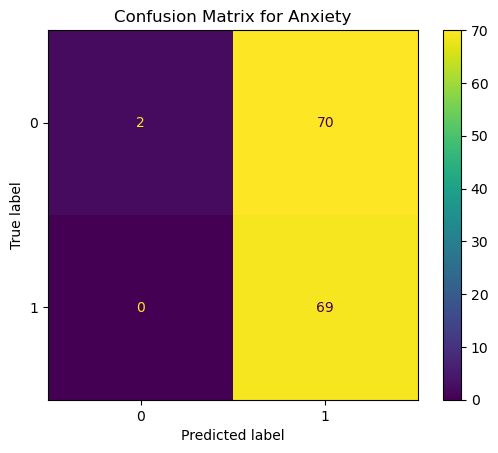

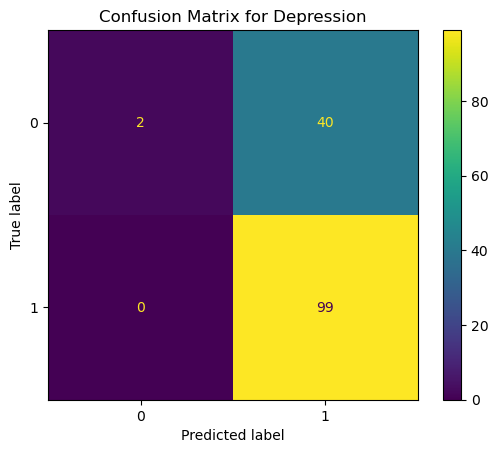

In [42]:
subset_name = 'male'
data = model_dict[subset_name]
from sklearn.metrics import multilabel_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
# Generate multiclass confusion matrices
matrices = multilabel_confusion_matrix(data['y_test'], data['y_pred'])

# Plotting matrices: code
cmd = ConfusionMatrixDisplay(matrices[0], display_labels=np.unique(data['y_test'])).plot()
plt.title('Confusion Matrix for Anxiety')
plt.show()
cmd = ConfusionMatrixDisplay(matrices[1], display_labels=np.unique(data['y_test'])).plot()
plt.title('Confusion Matrix for Depression')
plt.show()

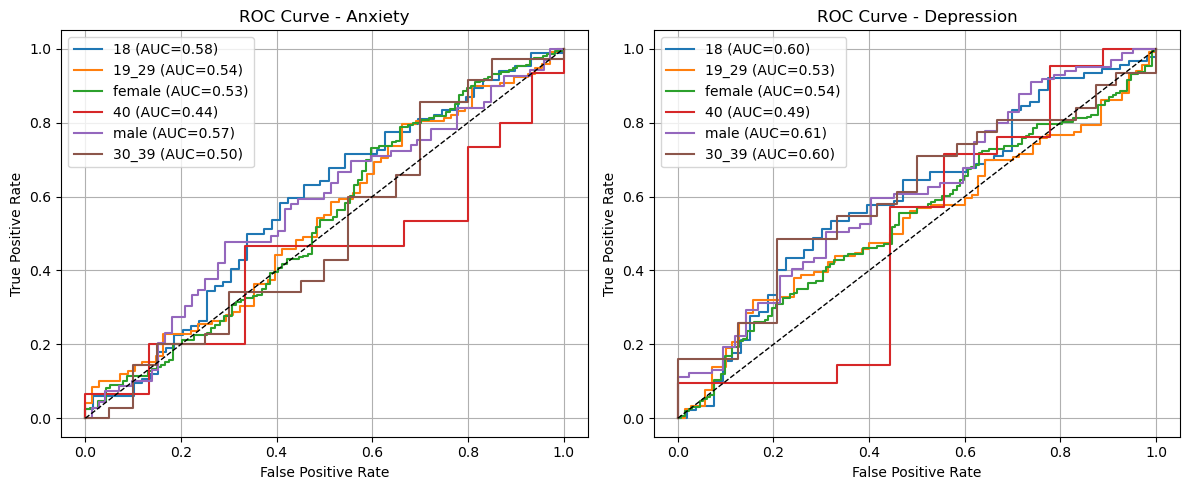

In [46]:
from sklearn.metrics import roc_curve, auc
import numpy as np

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

labels = ['Anxiety', 'Depression']
for i, label in enumerate(labels):
    plt.subplot(1, 2, i+1)
    for subset, d in model_dict.items():
        # Get true labels and predicted probabilities
        y_true = d['y_test'].iloc[:, i]
        # Get predicted probabilities if available, else use predictions
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(d['X_test'])[i][:, 1]
        else:
            # fallback: use predictions as probabilities (not ideal)
            y_score = d['y_pred'][:, i]
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{subset} (AUC={roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.title(f'ROC Curve - {label}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Function to plot ROC curves per label per subset
def plot_roc_curves(all_results, label_names=['Anxiety', 'Depression']):
    plt.figure(figsize=(12, 6))

    # Separate plots for Anxiety and Depression
    for i, label in enumerate(label_names):
        plt.subplot(1, 2, i+1)
        plt.title(f'ROC Curve - {label}')
        
        for subset, result in all_results.items():
            # Predict probabilities again (y_pred_proba)
            y_proba = result.clf.predict(result.X_test)  # result.X_test needs to be saved in NNResults
            
            if isinstance(y_proba, list):
                y_proba = y_proba[0]  # For Keras predict returning list

            fpr, tpr, _ = roc_curve(result.y_test.iloc[:, i], y_proba[:, i])
            roc_auc = auc(fpr, tpr)

            plt.plot(fpr, tpr, label=f'{subset} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random line
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.grid(True)

    plt.tight_layout()
    plt.show()